In [1]:
import os
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import contextily as ctx
from numpy import sqrt
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import TransformedTargetRegressor

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Adaboost

## Load data

In [2]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

1760

In [3]:
# df = df[df["soil region"] != "veen"]
# len(df)

## Sort by date

In [4]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove columns

In [5]:
# df = df.drop(columns=['soil region', 'landuse code'])
df = df.drop(columns=['soil region'])
df = df.dropna()
len(df)

952

## Add year and month as features

In [6]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [7]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [8]:
df.dtypes

bro-id                                   object
nitrate                                 float64
geometry                                 object
date                        datetime64[ns, UTC]
landuse code                           category
population                              float64
groundwater depth                       float64
elevation                               float64
lon                                     float64
lat                                     float64
precipitation                           float64
temperature                             float64
n deposition                            float64
mainsoilclassification_1               category
organicmattercontent_1                  float64
density_1                               float64
acidity_1                               float64
month                                     int32
year                                      int32
dtype: object

## Remove nitrate outliers

In [9]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 211


,bro-id,nitrate,geometry,date,landuse code,population,groundwater depth,elevation,lon,lat,precipitation,temperature,n deposition,mainsoilclassification_1,organicmattercontent_1,density_1,acidity_1,month,year
8,GAR000000034413,6.440,POINT (5.17098998 52.255863824),2008-08-12 11:00:00+00:00,22.0,0.0,0.025208,2.750871,5.170990,52.255864,14.00,175.450000,20.618304,Kalkloze zandgronden,4.0,1.355,4.8,8,2008
9,GAR000000034923,0.842,POINT (5.273031977 52.149856205),2008-08-12 11:00:00+00:00,11.0,0.0,2.917014,7.010535,5.273032,52.149856,14.00,175.450000,29.554770,Kalkloze zandgronden,3.0,1.473,3.4,8,2008
22,GAR000000050444,14.000,POINT (5.439743838 52.001456012),2008-09-16 10:00:00+00:00,11.0,15.0,5.036337,15.743617,5.439744,52.001456,2.25,173.216667,26.221104,Dikke eerdgronden,4.8,1.395,4.4,9,2008
23,GAR000000000644,9.000,POINT (5.391427046 52.01540844),2008-09-16 10:00:00+00:00,12.0,15.0,3.075021,20.816914,5.391427,52.015408,2.25,173.216667,30.661323,Kalkloze zandgronden,3.0,1.473,3.4,9,2008
30,GAR000000000449,0.500,POINT (5.470288289 52.044365667),2008-09-16 10:00:00+00:00,2.0,10.0,4.675278,12.031865,5.470288,52.044366,2.25,173.216667,26.277132,Podzolgronden,4.8,1.400,4.7,9,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,GAR000000043740,3.967,POINT (5.309488007 52.05155101),2022-08-10 11:00:00+00:00,251.0,100.0,3.669948,7.882928,5.309488,52.051551,0.00,184.416667,22.747368,Kalkloze zandgronden,3.0,1.473,3.4,8,2022
1694,GAR000000043830,0.928,POINT (5.273031977 52.149856205),2022-08-15 11:00:00+00:00,11.0,0.0,2.130075,7.010535,5.273032,52.149856,0.00,190.316667,21.976983,Kalkloze zandgronden,3.0,1.473,3.4,8,2022
1705,GAR000000043951,1.069,POINT (5.17098998 52.255863824),2023-06-12 11:00:00+00:00,28.0,0.0,0.492249,2.750871,5.170990,52.255864,0.00,132.100000,16.640316,Kalkloze zandgronden,4.0,1.355,4.8,6,2023
1722,GAR000000043864,5.438,POINT (5.309488007 52.05155101),2023-07-24 11:00:00+00:00,251.0,100.0,3.729424,7.882928,5.309488,52.051551,30.50,184.450000,23.363676,Kalkloze zandgronden,3.0,1.473,3.4,7,2023


<Axes: >

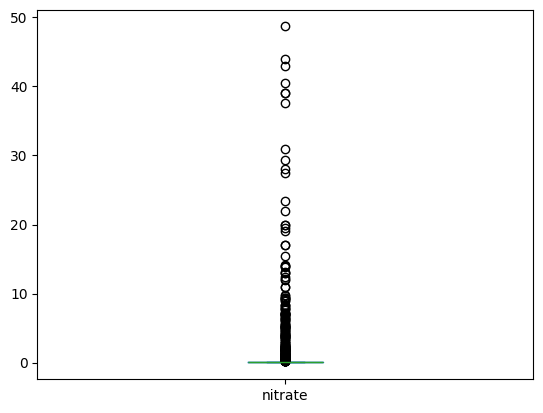

In [10]:
df[["nitrate"]].plot(kind = "box")

In [11]:
top_nitrate_outliers = list(df["nitrate"].sort_values()[-5:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

947

## Test / train split

In [12]:
n = len(df)
train_size = int(n * 0.8)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 757
Test: 190


In [13]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [14]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [15]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'mainsoilclassification_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['landuse code', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [16]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [17]:
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=100,
    learning_rate=0.1,
    random_state=4
)

In [18]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("ada", ada_reg)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [19]:
param_dist = {
    "regressor__ada__n_estimators": [50, 100, 150],
    "regressor__ada__learning_rate": [0.01, 0.1, 0.5],
    "regressor__ada__estimator__max_depth": [2, 4, 6]
}

## Hyperparameter tuning

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=60,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False), #"r2"
    verbose=1,
    random_state=9,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
best_params = search.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=60. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [21]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 0.5475807043881521
Best params: {'regressor__ada__n_estimators': 50, 'regressor__ada__learning_rate': 0.1, 'regressor__ada__estimator__max_depth': 6}


## Learning curve

In [22]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [23]:
n = len(X_train)

train_errors = []
val_errors = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=7)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))

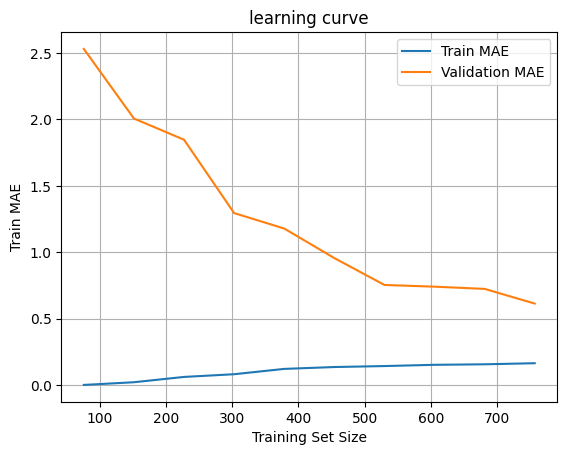

In [24]:
plt.plot(train_sizes * len(X_train), train_errors, label="Train MAE")
plt.plot(train_sizes * len(X_train), val_errors, label="Validation MAE")
plt.xlabel("Training Set Size")
plt.ylabel("Train MAE")
plt.title("learning curve")
plt.legend()
plt.grid(True)
plt.show()

## Train model

In [25]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('ada',
                                                      AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6),
                                                                        learning_rate=0.1,
                                                                        random_state=4))]))

## Final Train score

In [26]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.9744463542712642
Train MAE: 0.20504930233676982
Test RMSE: 0.6448407271560017


## Final Test score

In [27]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(y_test, pred_nitrate))
print("Test MAE:",mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_nitrate)))

Test R2: 0.7011635790667637
Test MAE: 0.20504930233676982
Test RMSE: 1.1146742281901616


## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

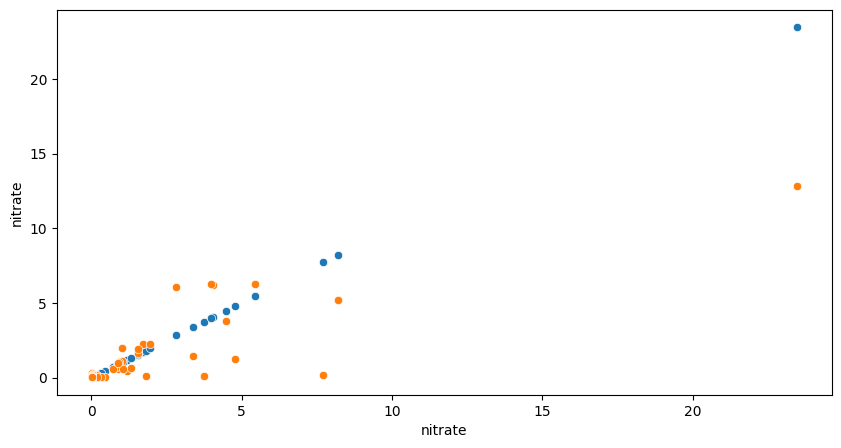

In [28]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

Text(0, 0.5, 'Residuals')

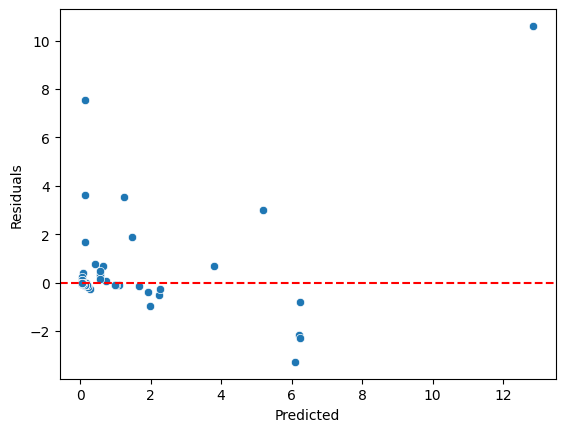

In [29]:
preds = best_model.predict(X_test)

residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Predictions on the map

In [30]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

190
190
190
190


In [31]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

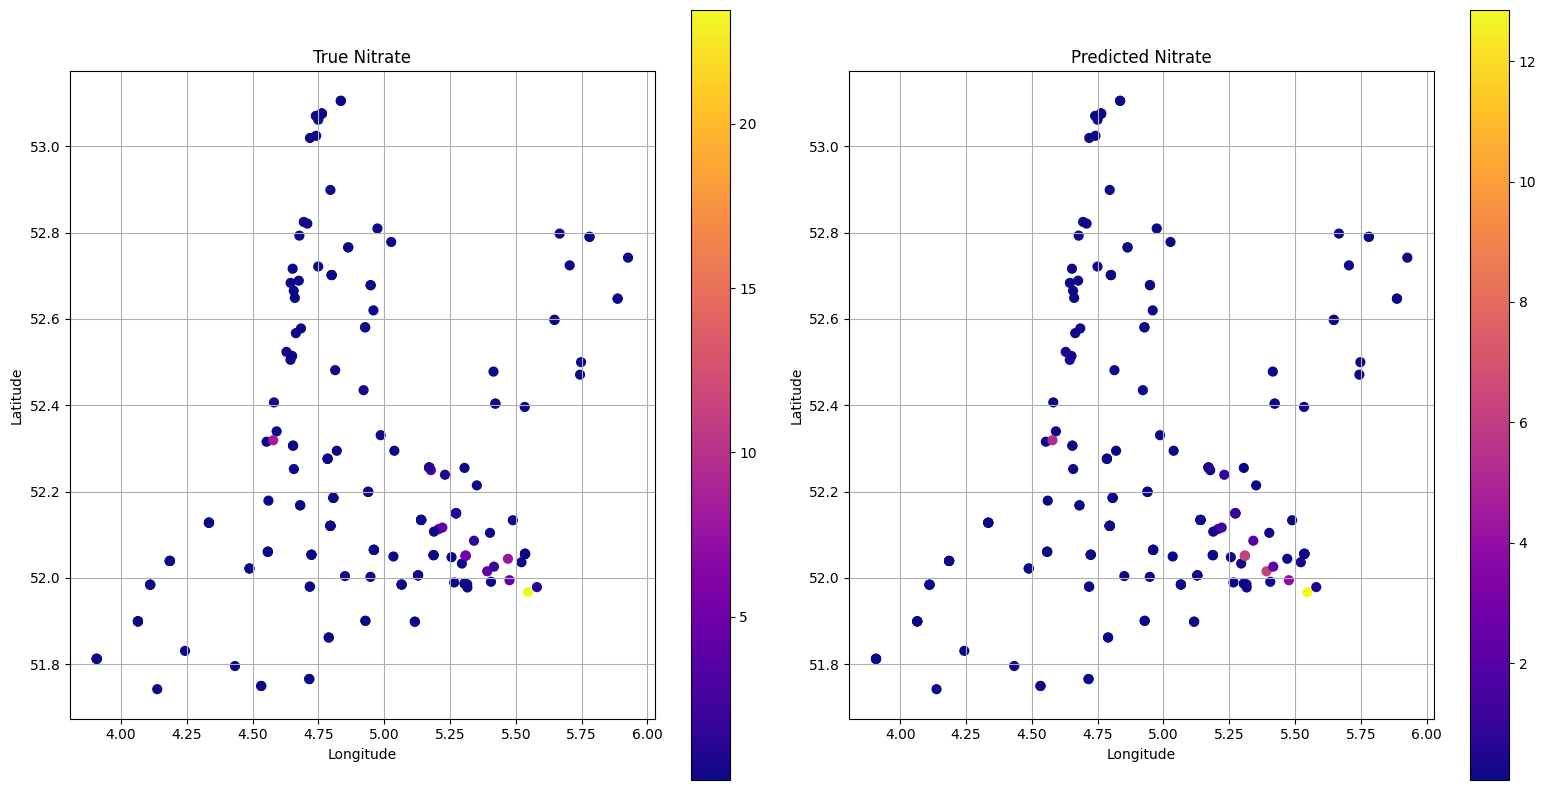

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

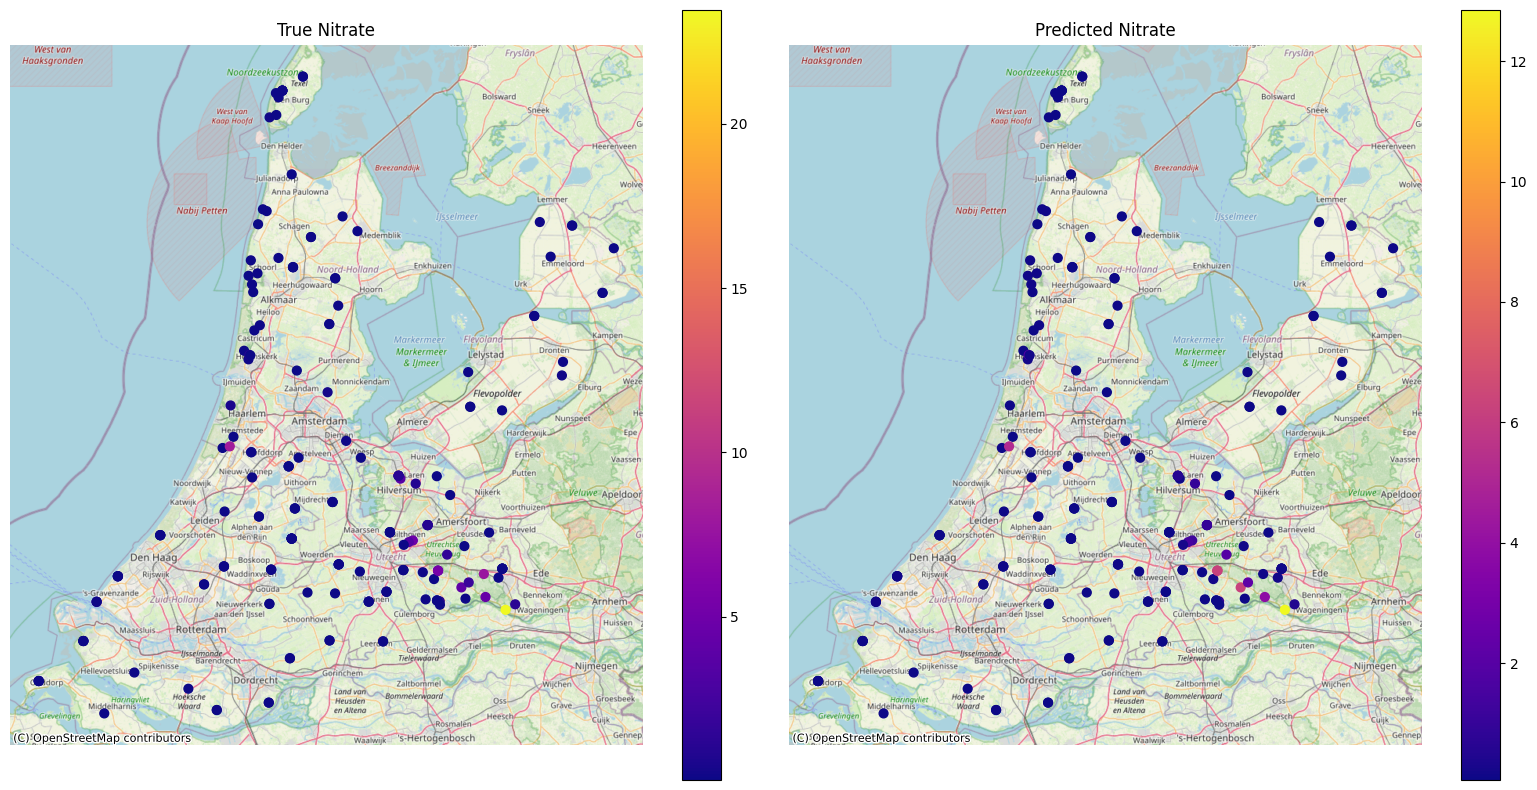

In [33]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Interpretability

In [34]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('ada',
                                                      AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6),
                                                                        learning_rate=0.1,
                                                                        random_state=4))]))

In [35]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [36]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['ada']

feature_names = fitted_preprocessor.get_feature_names_out()

### Default interpretability: Gain

In [37]:
importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature    importance
50                              num_scaler__acidity_1  3.356614e-01
44                              num_scaler__elevation  2.100023e-01
43                      num_scaler__groundwater depth  1.026409e-01
33  cat_ohe__mainsoilclassification_1_Dikke eerdgr...  7.838554e-02
47                           num_scaler__n deposition  7.137064e-02
42                             num_scaler__population  5.862397e-02
46                            num_scaler__temperature  3.208578e-02
49                              num_scaler__density_1  3.205516e-02
48                 num_scaler__organicmattercontent_1  2.201935e-02
45                          num_scaler__precipitation  9.159704e-03
14                         cat_ohe__landuse code_22.0  7.094561e-03
28                         cat_ohe__landuse code_46.0  6.462099e-03
16                         cat_ohe__landuse code_25.0  5.732787e-03
36  cat_ohe__mainsoilclassification_1_Kalkloze z

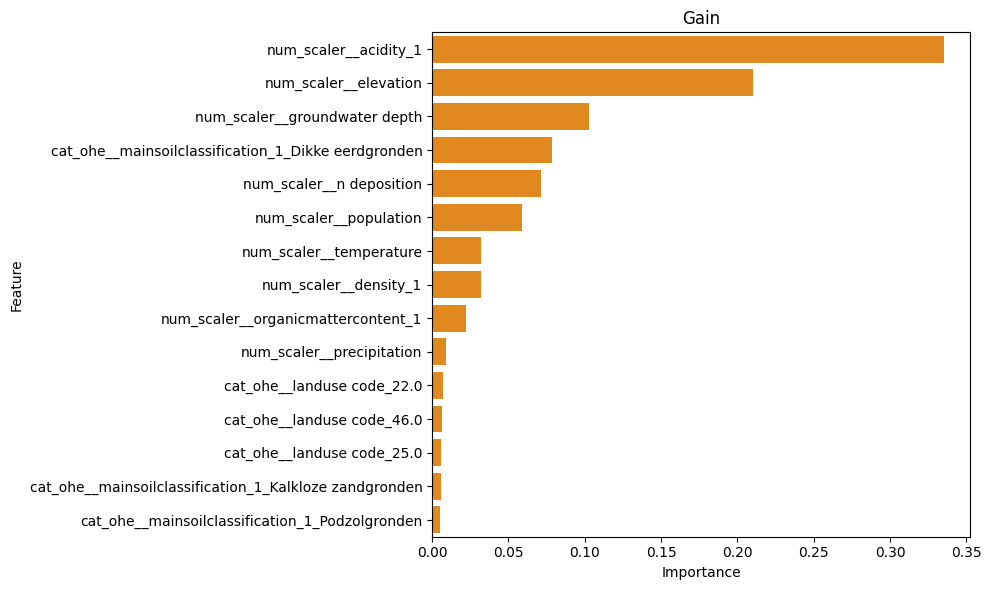

In [38]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Gain")
plt.tight_layout()
plt.show()

In [39]:
booster = fitted_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

importance_types = ["gain", "cover", "weight"]
# importance_types = ["gain"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

AttributeError: 'AdaBoostRegressor' object has no attribute 'get_booster'

In [198]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

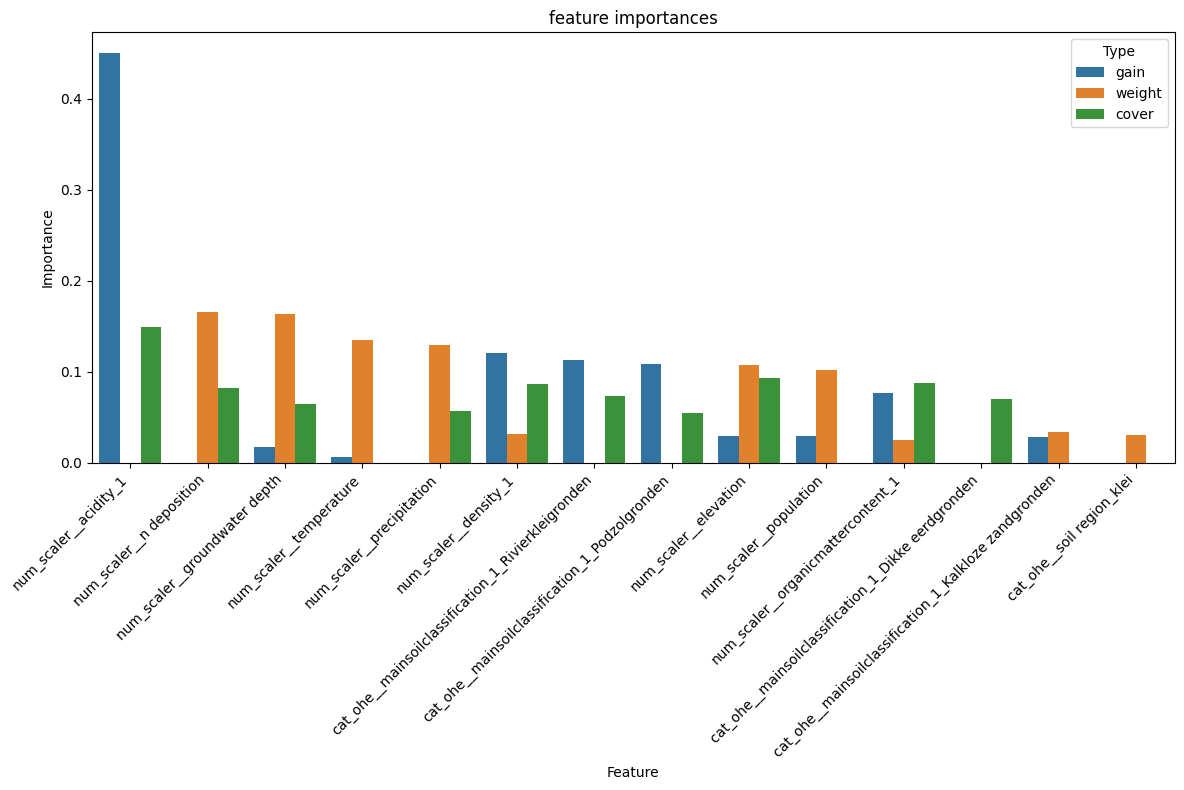

In [199]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("feature importances")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [200]:
assert fitted_model.n_features_in_ == len(feature_names)

In [201]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

## Permutation

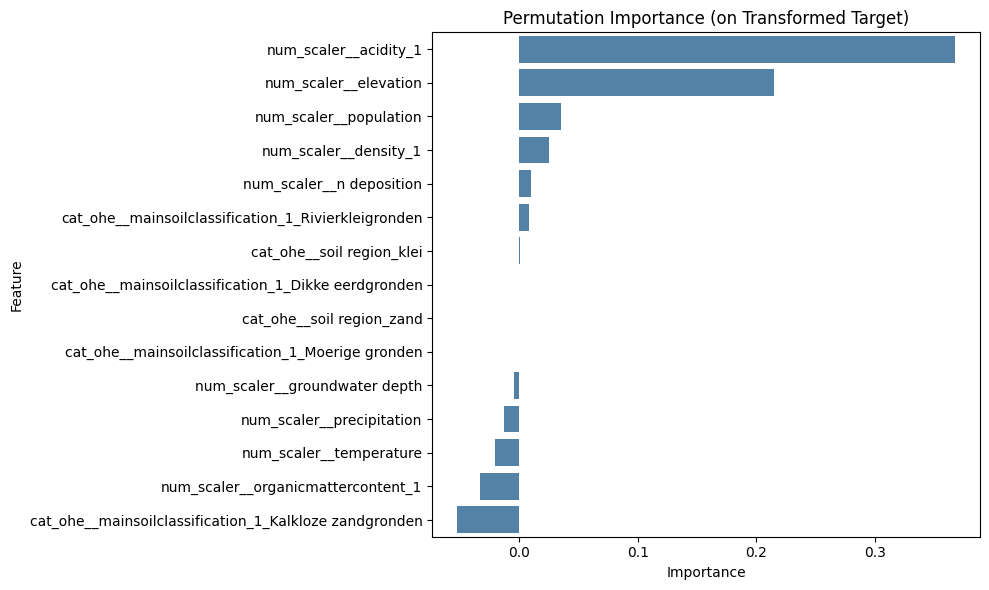

In [202]:
# If your target was transformed using log1p, reverse it before comparing
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

# Run permutation importance
perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


In [203]:
perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"

combined_df = pd.concat([importances_df, perm_df], axis=0)

In [204]:
combined_df

,Feature,Importance,Type,Std
0,cat_ohe__soil region_klei,0.005304,gain,NaN
1,cat_ohe__soil region_zand,0.000443,gain,NaN
2,cat_ohe__mainsoilclassification_1_Dikke eerdgr...,0.004913,gain,NaN
3,cat_ohe__mainsoilclassification_1_Kalkloze zan...,0.028474,gain,NaN
4,cat_ohe__mainsoilclassification_1_Moerige gronden,0.000579,gain,NaN
...,...,...,...,...
10,num_scaler__precipitation,-0.029115,permutation,0.014536
11,num_scaler__temperature,-0.046882,permutation,0.018076
13,num_scaler__organicmattercontent_1,-0.074961,permutation,0.016787
3,cat_ohe__mainsoilclassification_1_Kalkloze zan...,-0.118993,permutation,0.033319


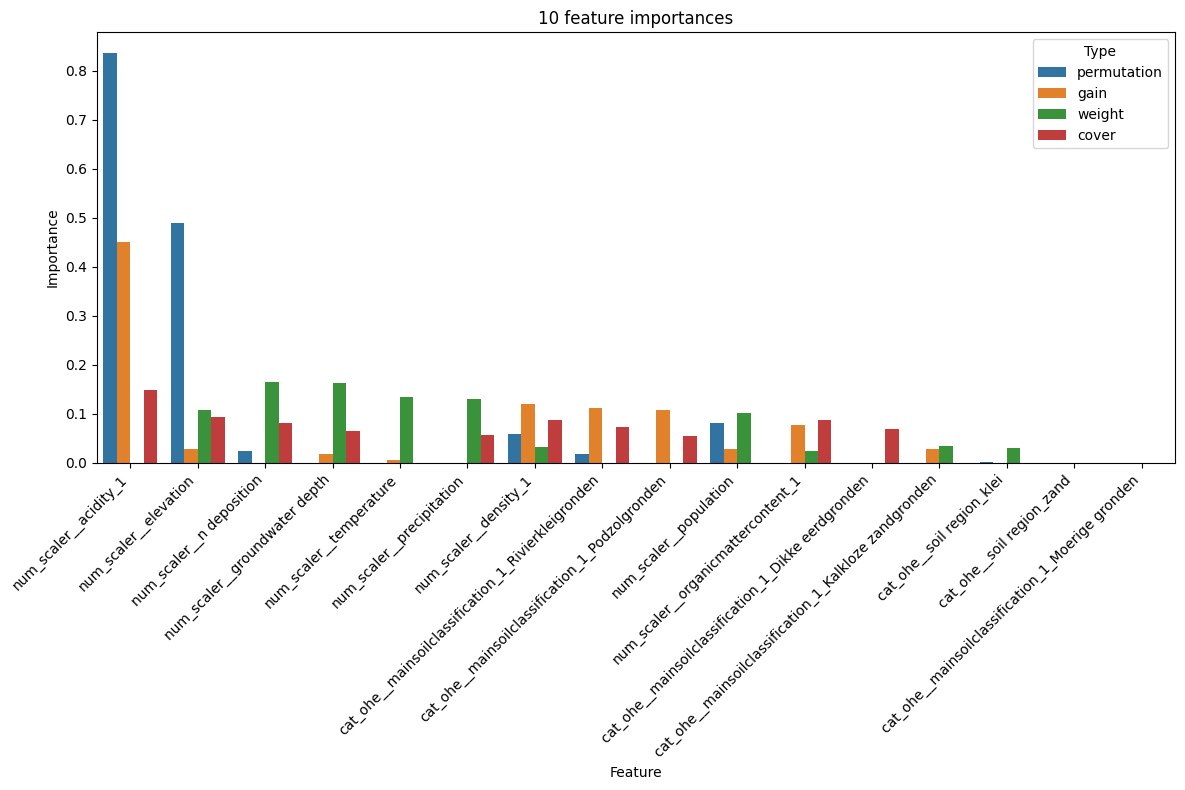

In [205]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

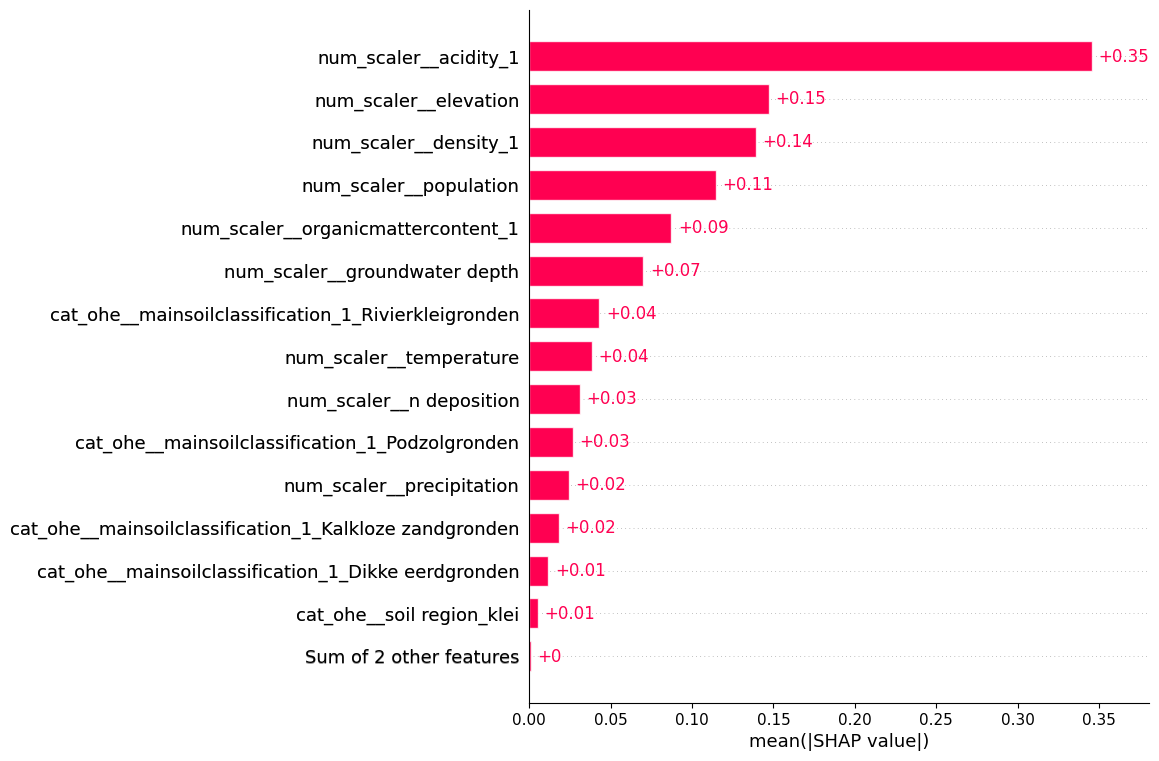

In [206]:
X_test_transformed = fitted_preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(fitted_model)

shap_values = explainer(X_test_transformed)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)


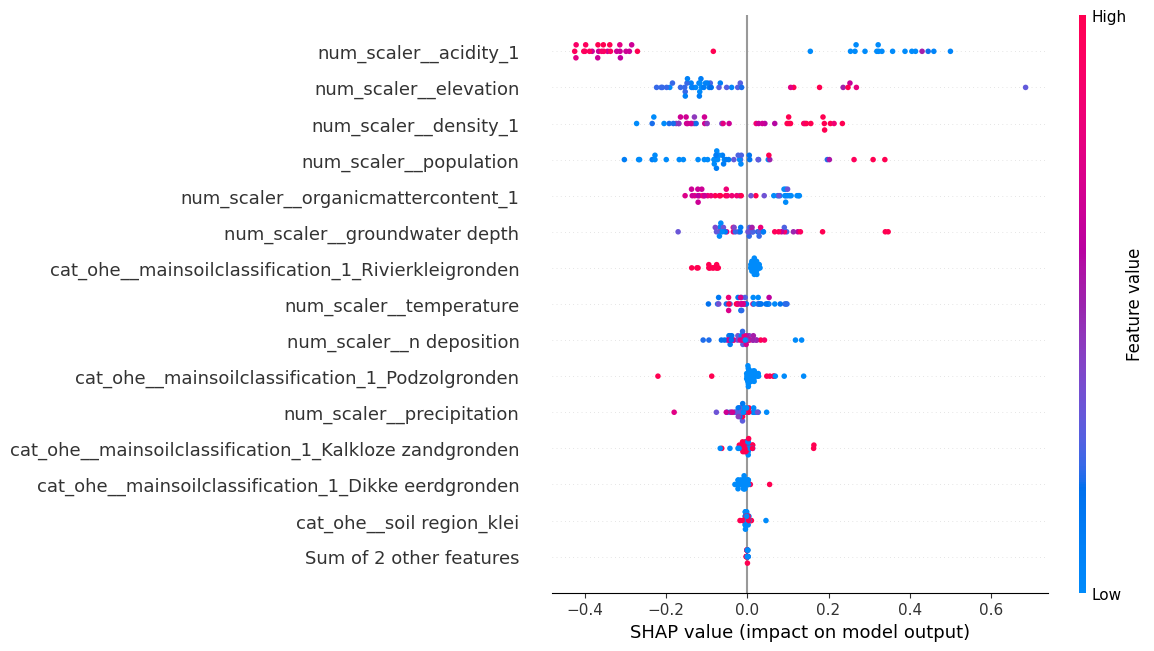

In [207]:
shap.plots.beeswarm(shap_explanation, max_display=15)